# Predict Bike Trips

In this tutorial, build a machine learning application to predict the number of bike trips from a station in the next biking period. This application is structured into three important steps:

- Prediction Engineering
- Feature Engineering
- Machine Learning

In the first step, create new labels from the data by using [Compose](https://compose.alteryx.com/). In the second step, generate features for the labels by using [Featuretools](https://featuretools.alteryx.com/). In the third step, search for the best machine learning pipeline using [EvalML](https://evalml.alteryx.com/). After working through these steps, you should understand how to build machine learning applications for real-world problems like forecasting demand.

#### Note: In order to run this example, you should have Featuretools 1.4.0 or newer and EvalML 0.41.0 or newer installed.

In [1]:
from demo.chicago_bike import load_sample
from matplotlib.pyplot import subplots
import composeml as cp
import featuretools as ft
import evalml

Use data provided by [Divvy](https://www.kaggle.com/yingwurenjian/chicago-divvy-bicycle-sharing-data), a bike share in Chicago. In this dataset, we have a record of each bike trip.

In [2]:
df = load_sample()
df.head()

,gender,starttime,stoptime,tripduration,temperature,events,from_station_id,dpcapacity_start,to_station_id,dpcapacity_end
trip_id,,,,,,,,,,
2331610,Female,2014-06-29 13:35:00,2014-06-29 13:56:00,20.750000,82.9,cloudy,178,15.0,76,39.0
2347603,Female,2014-06-30 12:07:00,2014-06-30 12:37:00,30.150000,82.0,cloudy,211,19.0,177,15.0
2345120,Male,2014-06-30 08:36:00,2014-06-30 08:43:00,6.516667,75.0,cloudy,340,15.0,67,15.0
2347527,Male,2014-06-30 12:00:00,2014-06-30 12:08:00,7.250000,82.0,cloudy,56,19.0,56,19.0
2344421,Male,2014-06-30 08:04:00,2014-06-30 08:11:00,7.316667,75.0,cloudy,77,23.0,37,19.0


## Prediction Engineering

> How many trips will occur from a station in the next biking period?

You can change the length of the biking period to create different prediction problems. For example, how many bike trips will occur in the next 13 hours or the next week? Those variations can be done by simply tweaking a parameter. This helps you understand different scenarios that are crucial for making better decisions.

### Defining the Labeling Function

Define a labeling function to calculate the number of trips. Given that each observation is an individual trip, the number of trips is just the number of observations. Your labeling function should be used by a label maker to extract the training examples.

In [3]:
def trip_count(ds):
    return len(ds)

### Representing the Prediction Problem

Represent the prediction problem by creating a label maker with the following parameters:

- `target_entity` as the column for station ID where each trip starts from, since you want to process trips from each station.
- `labeling_function` as the function to calculate the number of trips.
- `time_index` as the column for the starting time of a trip. The biking periods are based on this time index.
- `window_size` as the length of a biking period. You can easily change this parameter to create variations of the prediction problem.

In [4]:
lm = cp.LabelMaker(
    target_entity='from_station_id',
    labeling_function=trip_count,
    time_index='starttime',
    window_size='13h',
)

### Finding the Training Examples

Run a search to get the training examples by using the following parameters:

- The trips sorted by the start time, since the search expects the trips to be sorted chronologically, otherwise an error is raised.
- `num_examples_per_instance` to find the number of training examples per station. In this case, the search returns all existing examples.
- `minimum_data` as the start time of the first biking period. This is also the first cutoff time for building features.

In [5]:
lt = lm.search(
    df.sort_values('starttime'),
    num_examples_per_instance=-1,
    minimum_data='2014-06-30 08:00',
    verbose=False,
)

lt.head()

,from_station_id,time,trip_count
0,5,2014-06-30 08:00:00,3
1,15,2014-06-30 08:00:00,1
2,16,2014-06-30 08:00:00,1
3,17,2014-06-30 08:00:00,2
4,19,2014-06-30 08:00:00,2


The output from the search is a label times table with three columns:

- The station ID associated to the trips. There can be many training examples generated from each station.
- The start time of the biking period. This is also the cutoff time for building features. Only data that existed beforehand is valid to use for predictions.
- The number of trips during the biking period window. This is calculated by our labeling function.

As a helpful reference, you can print out the search settings that were used to generate these labels.

In [6]:
lt.describe()

Label Distribution
------------------
count    212.000000
mean       2.669811
std        2.367720
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       13.000000


Settings
--------
gap                                      None
maximum_data                             None
minimum_data                 2014-06-30 08:00
num_examples_per_instance                  -1
target_column                      trip_count
target_entity                 from_station_id
target_type                        continuous
window_size                               13h


Transforms
----------
No transforms applied



You can also get a better look at the labels by plotting the distribution and cumulative count across time.

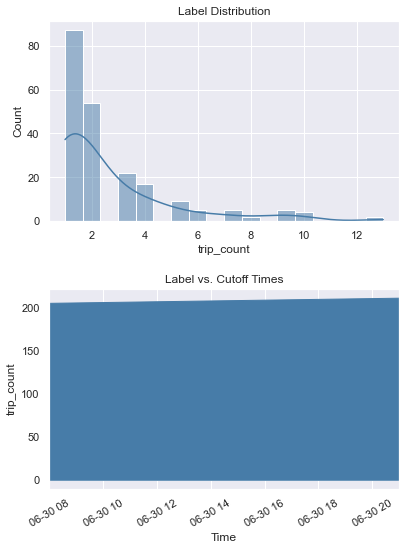

In [7]:
%matplotlib inline
fig, ax = subplots(nrows=2, ncols=1, figsize=(6, 8))
lt.plot.distribution(ax=ax[0])
lt.plot.count_by_time(ax=ax[1])
fig.tight_layout(pad=2)

## Feature Engineering

In the previous step, you generated the labels. The next step is to generate features.

### Representing the Data

Start by representing the data with an EntitySet. That way, you can generate features based on the relational structure of the dataset. You currently have a single table of trips where one station can have many trips. This one-to-many relationship can be represented by normalizing a station dataframe. The same can be done with other one-to-many relationships like weather-to-trips. Because you want to make predictions based on the station where the trips started from, you should use this station dataframe as the target for generating features. Also, you should use the stop times of the trips as the time index for generating features, since data about a trip would likely be unavailable until the trip is complete.

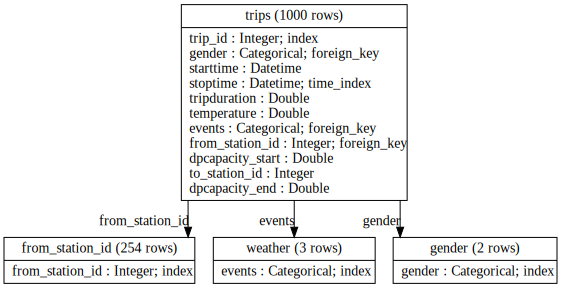

In [8]:
es = ft.EntitySet('chicago_bike')

es.add_dataframe(
    dataframe=df.reset_index(),
    dataframe_name='trips',
    time_index='stoptime',
    index='trip_id',
)

es.normalize_dataframe(
    base_dataframe_name='trips',
    new_dataframe_name='from_station_id',
    index='from_station_id',
    make_time_index=False,
)

es.normalize_dataframe(
    base_dataframe_name='trips',
    new_dataframe_name='weather',
    index='events',
    make_time_index=False,
)

es.normalize_dataframe(
    base_dataframe_name='trips',
    new_dataframe_name='gender',
    index='gender',
    make_time_index=False,
)

es.add_interesting_values(dataframe_name='trips',
                          values={'gender': ['Male', 'Female'],
                                  'events': ['tstorms']})
es.plot()

### Calculating the Features

Generate features using a method called Deep Feature Synthesis (DFS). The method automatically builds features by stacking and applying mathematical operations called primitives across relationships in an entityset. The more structured an entityset is, the better DFS can leverage the relationships to generate better features. Run DFS with the following parameters:

- `entityset` as the entitset we structured previously.
- `target_dataframe_name` as the station dataframe where the trips started from.
- `cutoff_time` as the label times that we generated previously. The label values are appended to the feature matrix.

In [9]:
fm, fd = ft.dfs(
    entityset=es,
    target_dataframe_name='from_station_id',
    trans_primitives=['hour', 'week', 'is_weekend'],
    cutoff_time=lt,
    cutoff_time_in_index=True,
    include_cutoff_time=False,
    verbose=False,
)

fm.head()

,,COUNT(trips),MAX(trips.dpcapacity_end),MAX(trips.dpcapacity_start),MAX(trips.temperature),MAX(trips.to_station_id),MAX(trips.tripduration),MEAN(trips.dpcapacity_end),MEAN(trips.dpcapacity_start),MEAN(trips.temperature),MEAN(trips.to_station_id),...,MODE(trips.HOUR(stoptime)),MODE(trips.WEEK(starttime)),MODE(trips.WEEK(stoptime)),NUM_UNIQUE(trips.HOUR(starttime)),NUM_UNIQUE(trips.HOUR(stoptime)),NUM_UNIQUE(trips.WEEK(starttime)),NUM_UNIQUE(trips.WEEK(stoptime)),PERCENT_TRUE(trips.IS_WEEKEND(starttime)),PERCENT_TRUE(trips.IS_WEEKEND(stoptime)),trip_count
from_station_id,time,,,,,,,,,,,,,,,,,,,,,
5,2014-06-30 08:00:00,1,39.0,19.0,84.0,76.0,9.233333,39.000000,19.0,84.000000,76.000000,...,14,26,26,1,1,1,1,1.000000,1.000000,3
15,2014-06-30 08:00:00,3,19.0,15.0,84.2,280.0,14.166667,16.333333,15.0,76.733333,137.333333,...,7,27,27,3,2,2,2,0.333333,0.333333,1
16,2014-06-30 08:00:00,2,15.0,11.0,84.9,340.0,25.083333,13.000000,11.0,84.900000,324.500000,...,17,26,26,1,2,1,1,1.000000,1.000000,1
17,2014-06-30 08:00:00,1,15.0,15.0,84.9,183.0,4.650000,15.000000,15.0,84.900000,183.000000,...,17,26,26,1,1,1,1,1.000000,1.000000,2
19,2014-06-30 08:00:00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,0.000000,0.000000,2


There are two outputs from DFS: a feature matrix and feature definitions. The feature matrix is a table that contains the feature values with the corresponding labels based on the cutoff times. Feature definitions are features in a list that can be stored and reused later to calculate the same set of features on future data.

## Machine Learning

In the previous steps, you generated the labels and features. The final step is to build the machine learning pipeline.

### Splitting the Data

Start by extracting the labels from the feature matrix and splitting the data into a training set and a holdout set.

In [10]:
fm.reset_index(drop=True, inplace=True)
y = fm.ww.pop('trip_count')

splits = evalml.preprocessing.split_data(
    X=fm,
    y=y,
    test_size=0.1,
    random_seed=0,
    problem_type='regression',
)

X_train, X_holdout, y_train, y_holdout = splits

### Finding the Best Model

Run a search on the training set to find the best machine learning model. During the search process, predictions from several different pipelines are evaluated.

In [11]:
automl = evalml.AutoMLSearch(
    X_train=X_train,
    y_train=y_train,
    problem_type='regression',
    objective='r2',
    random_seed=3,
    allowed_model_families=['extra_trees', 'random_forest'],
    max_iterations=3,
)

automl.search(show_iteration_plot=False)

Once the search is complete, you can print out information about the best pipeline, like the parameters in each component.


*******************************************************************************************
* Extra Trees Regressor w/ Replace Nullable Types Transformer + Imputer + One Hot Encoder *
*******************************************************************************************

Problem Type: regression
Model Family: Extra Trees
Number of features: 84

Pipeline Steps
1. Replace Nullable Types Transformer
2. Imputer
	 * categorical_impute_strategy : most_frequent
	 * numeric_impute_strategy : mean
	 * categorical_fill_value : None
	 * numeric_fill_value : None
3. One Hot Encoder
	 * top_n : 10
	 * features_to_encode : None
	 * categories : None
	 * drop : if_binary
	 * handle_unknown : ignore
	 * handle_missing : error
4. Extra Trees Regressor
	 * n_estimators : 100
	 * max_features : auto
	 * max_depth : 6
	 * min_samples_split : 2
	 * min_weight_fraction_leaf : 0.0
	 * n_jobs : -1


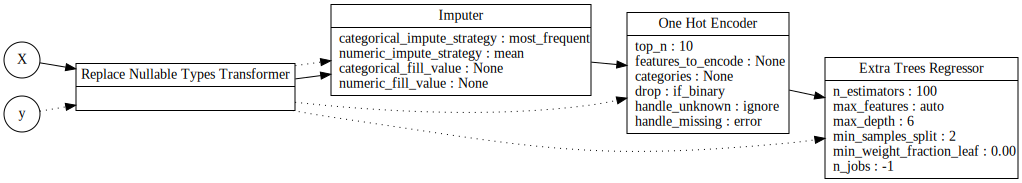

In [12]:
automl.best_pipeline.describe()
automl.best_pipeline.graph()

Let’s score the model performance by evaluating predictions on the holdout set.

In [13]:
best_pipeline = automl.best_pipeline.fit(X_train, y_train)

score = best_pipeline.score(
    X=X_holdout,
    y=y_holdout,
    objectives=['r2'],
)

dict(score)

{'R2': 0.2648844402933116}

From the pipeline, you can see which features are most important for predictions.

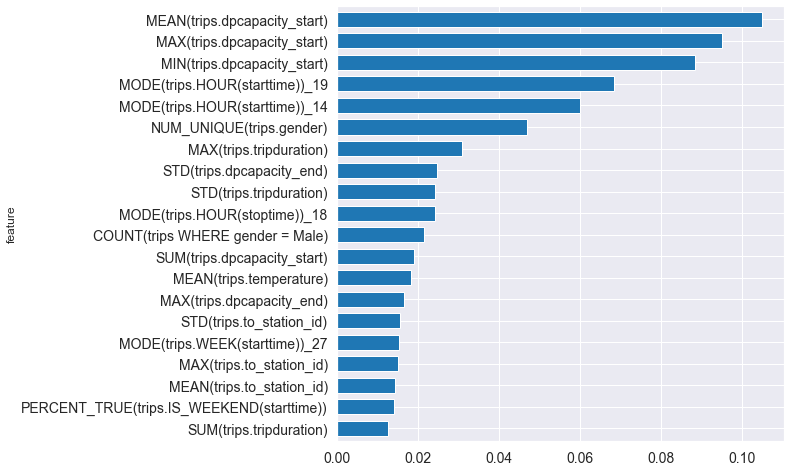

In [14]:
feature_importance = best_pipeline.feature_importance
feature_importance = feature_importance.set_index('feature')['importance']
top_k = feature_importance.abs().sort_values().tail(20).index
feature_importance[top_k].plot.barh(figsize=(8, 8), fontsize=14, width=.7);

### Making Predictions

Now you are ready to make predictions with your trained model. Start by calculating the same set of features by using the feature definitions. Then use a cutoff time based on the latest information available in the dataset.

In [15]:
fm = ft.calculate_feature_matrix(
    features=fd,
    entityset=es,
    cutoff_time=ft.pd.Timestamp('2014-07-02 08:00:00'),
    cutoff_time_in_index=True,
    verbose=False,
)

fm.head()

,,COUNT(trips),MAX(trips.dpcapacity_end),MAX(trips.dpcapacity_start),MAX(trips.temperature),MAX(trips.to_station_id),MAX(trips.tripduration),MEAN(trips.dpcapacity_end),MEAN(trips.dpcapacity_start),MEAN(trips.temperature),MEAN(trips.to_station_id),...,MODE(trips.HOUR(starttime)),MODE(trips.HOUR(stoptime)),MODE(trips.WEEK(starttime)),MODE(trips.WEEK(stoptime)),NUM_UNIQUE(trips.HOUR(starttime)),NUM_UNIQUE(trips.HOUR(stoptime)),NUM_UNIQUE(trips.WEEK(starttime)),NUM_UNIQUE(trips.WEEK(stoptime)),PERCENT_TRUE(trips.IS_WEEKEND(starttime)),PERCENT_TRUE(trips.IS_WEEKEND(stoptime))
from_station_id,time,,,,,,,,,,,,,,,,,,,,,
186,2014-07-02 08:00:00,1,19.0,15.0,82.9,56.0,6.483333,19.000000,15.0,82.900000,56.000000,...,13,13,26,26,1,1,1,1,1.00000,1.00000
181,2014-07-02 08:00:00,8,27.0,31.0,84.9,233.0,18.350000,20.500000,31.0,83.212500,140.750000,...,16,16,27,27,5,5,2,2,0.37500,0.37500
177,2014-07-02 08:00:00,23,31.0,15.0,84.9,334.0,50.233333,17.434783,15.0,83.334783,219.565217,...,16,18,26,26,8,8,2,2,0.73913,0.73913
13,2014-07-02 08:00:00,3,19.0,19.0,82.9,165.0,13.916667,17.666667,19.0,82.600000,112.666667,...,13,13,26,26,2,2,1,1,1.00000,1.00000
153,2014-07-02 08:00:00,2,23.0,19.0,82.9,324.0,13.850000,19.000000,19.0,77.950000,219.500000,...,6,6,26,26,2,2,2,2,0.50000,0.50000


Predict the number of trips that will occur from a station in the next 13 hours.

In [16]:
y_pred = best_pipeline.predict(fm)
y_pred = y_pred.values.round()

prediction = fm[[]]
prediction['trip_count (estimate)'] = y_pred
prediction.head()

,,trip_count (estimate)
from_station_id,time,
186,2014-07-02 08:00:00,1.0
181,2014-07-02 08:00:00,5.0
177,2014-07-02 08:00:00,5.0
13,2014-07-02 08:00:00,3.0
153,2014-07-02 08:00:00,3.0


### Next Steps

You have completed this tutorial. You can revisit each step to explore and fine-tune the model using different parameters until it is ready for production. For more information about how to work with the features produced by Featuretools, take a look at [the Featuretools documentation](https://featuretools.alteryx.com/). For more information about how to work with the models produced by EvalML, take a look at [the EvalML documentation](https://evalml.alteryx.com/).